### Imports

In [1]:
from collections import defaultdict
import os
from pprint import pprint

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 500
import seaborn as sns
sns.set_style("white")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### Helpful functions, variables

In [2]:
def compress_binary_array(arr):
    """ compress binary array (e.g., array of incorrect / correct labels) by
        converting consecutive subsequences of 0s / 1s into single 0 / 1 """
    return arr if arr.size == 0 else arr[np.insert(np.diff(arr) != 0, 0, True)]


def key(fname):
    """ key for sorting results files based on checkpoints step """
    dirname = os.path.basename(os.path.dirname(fname))
    for part in dirname.split("-"):
        if "step" in part:
            return int(part.replace("step", ""))
    raise RuntimeError("'step' not found in dirname")

datasets = ["mmlu", "openbookqa", "sciq"]
metrics = {
    "mmlu" : "acc_per_char",
    "openbookqa" : "acc_uncond",
    "sciq" : "acc_per_char",
}
subsets = {
    "mmlu" : "57subj",
    "openbookqa" : "xlarge",
    "sciq" : "xlarge",
}
titles = {
    "mmlu" : "MMLU",
    "openbookqa" : "OpenBookQA",
    "sciq" : "SciQ",
}

### Get correctness labels for all instances (for all relations) and all steps

In [3]:
basedir = f"{os.environ['HOME']}/projects/pretrain-intervention/results/eval"
fmt = "labels_olmo2_1b_retr_step_500_to_10000_{dataset}_{subset}_0shot_cf_{metric}.npz"
fmt_fn = lambda x: fmt.format(dataset=x, subset=subsets[x], metric=metrics[x].split("_")[-1])

labels = {
    dataset : np.load(os.path.join(basedir, fmt_fn(dataset)))["labels"]
              for dataset in datasets
}

print("labels shapes:", {k : v.shape for k, v in labels.items()})
ckpt_steps = np.arange(500, 10500, 500)

labels shapes: {'mmlu': (14042, 20), 'openbookqa': (5957, 20), 'sciq': (13679, 20)}


### Plot performance of OLMo-2-0425-1B on all datasets

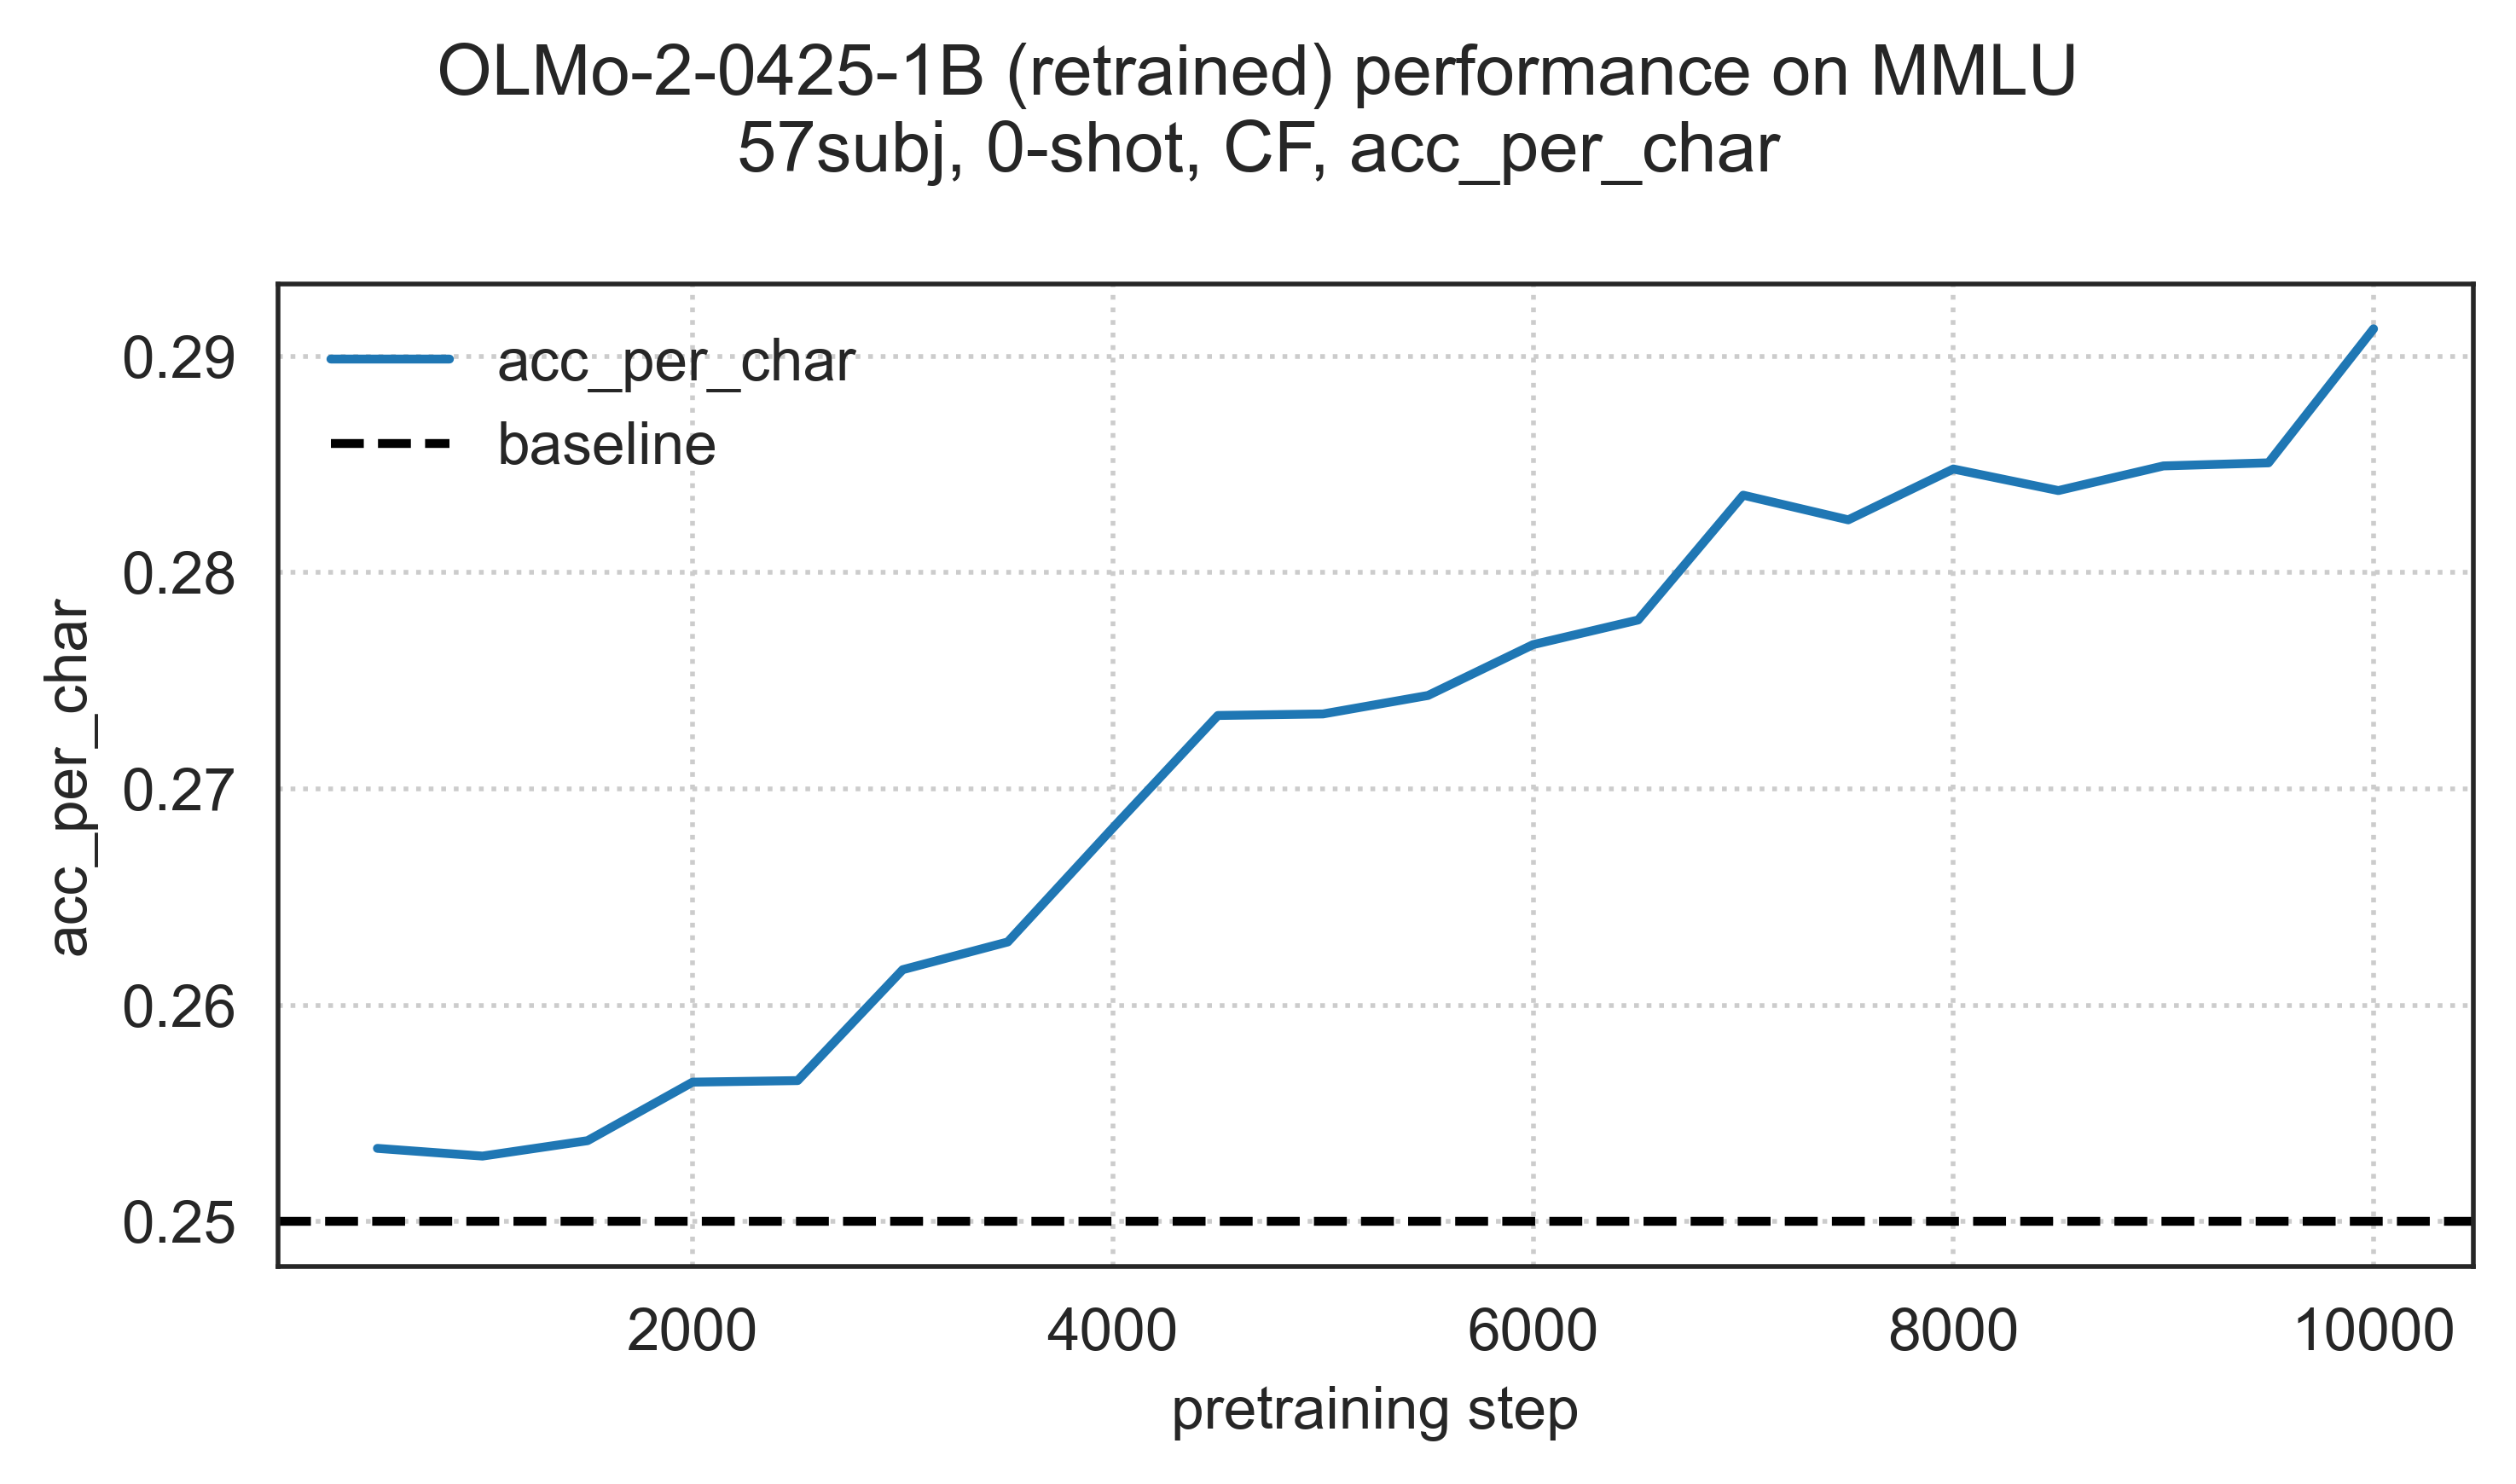

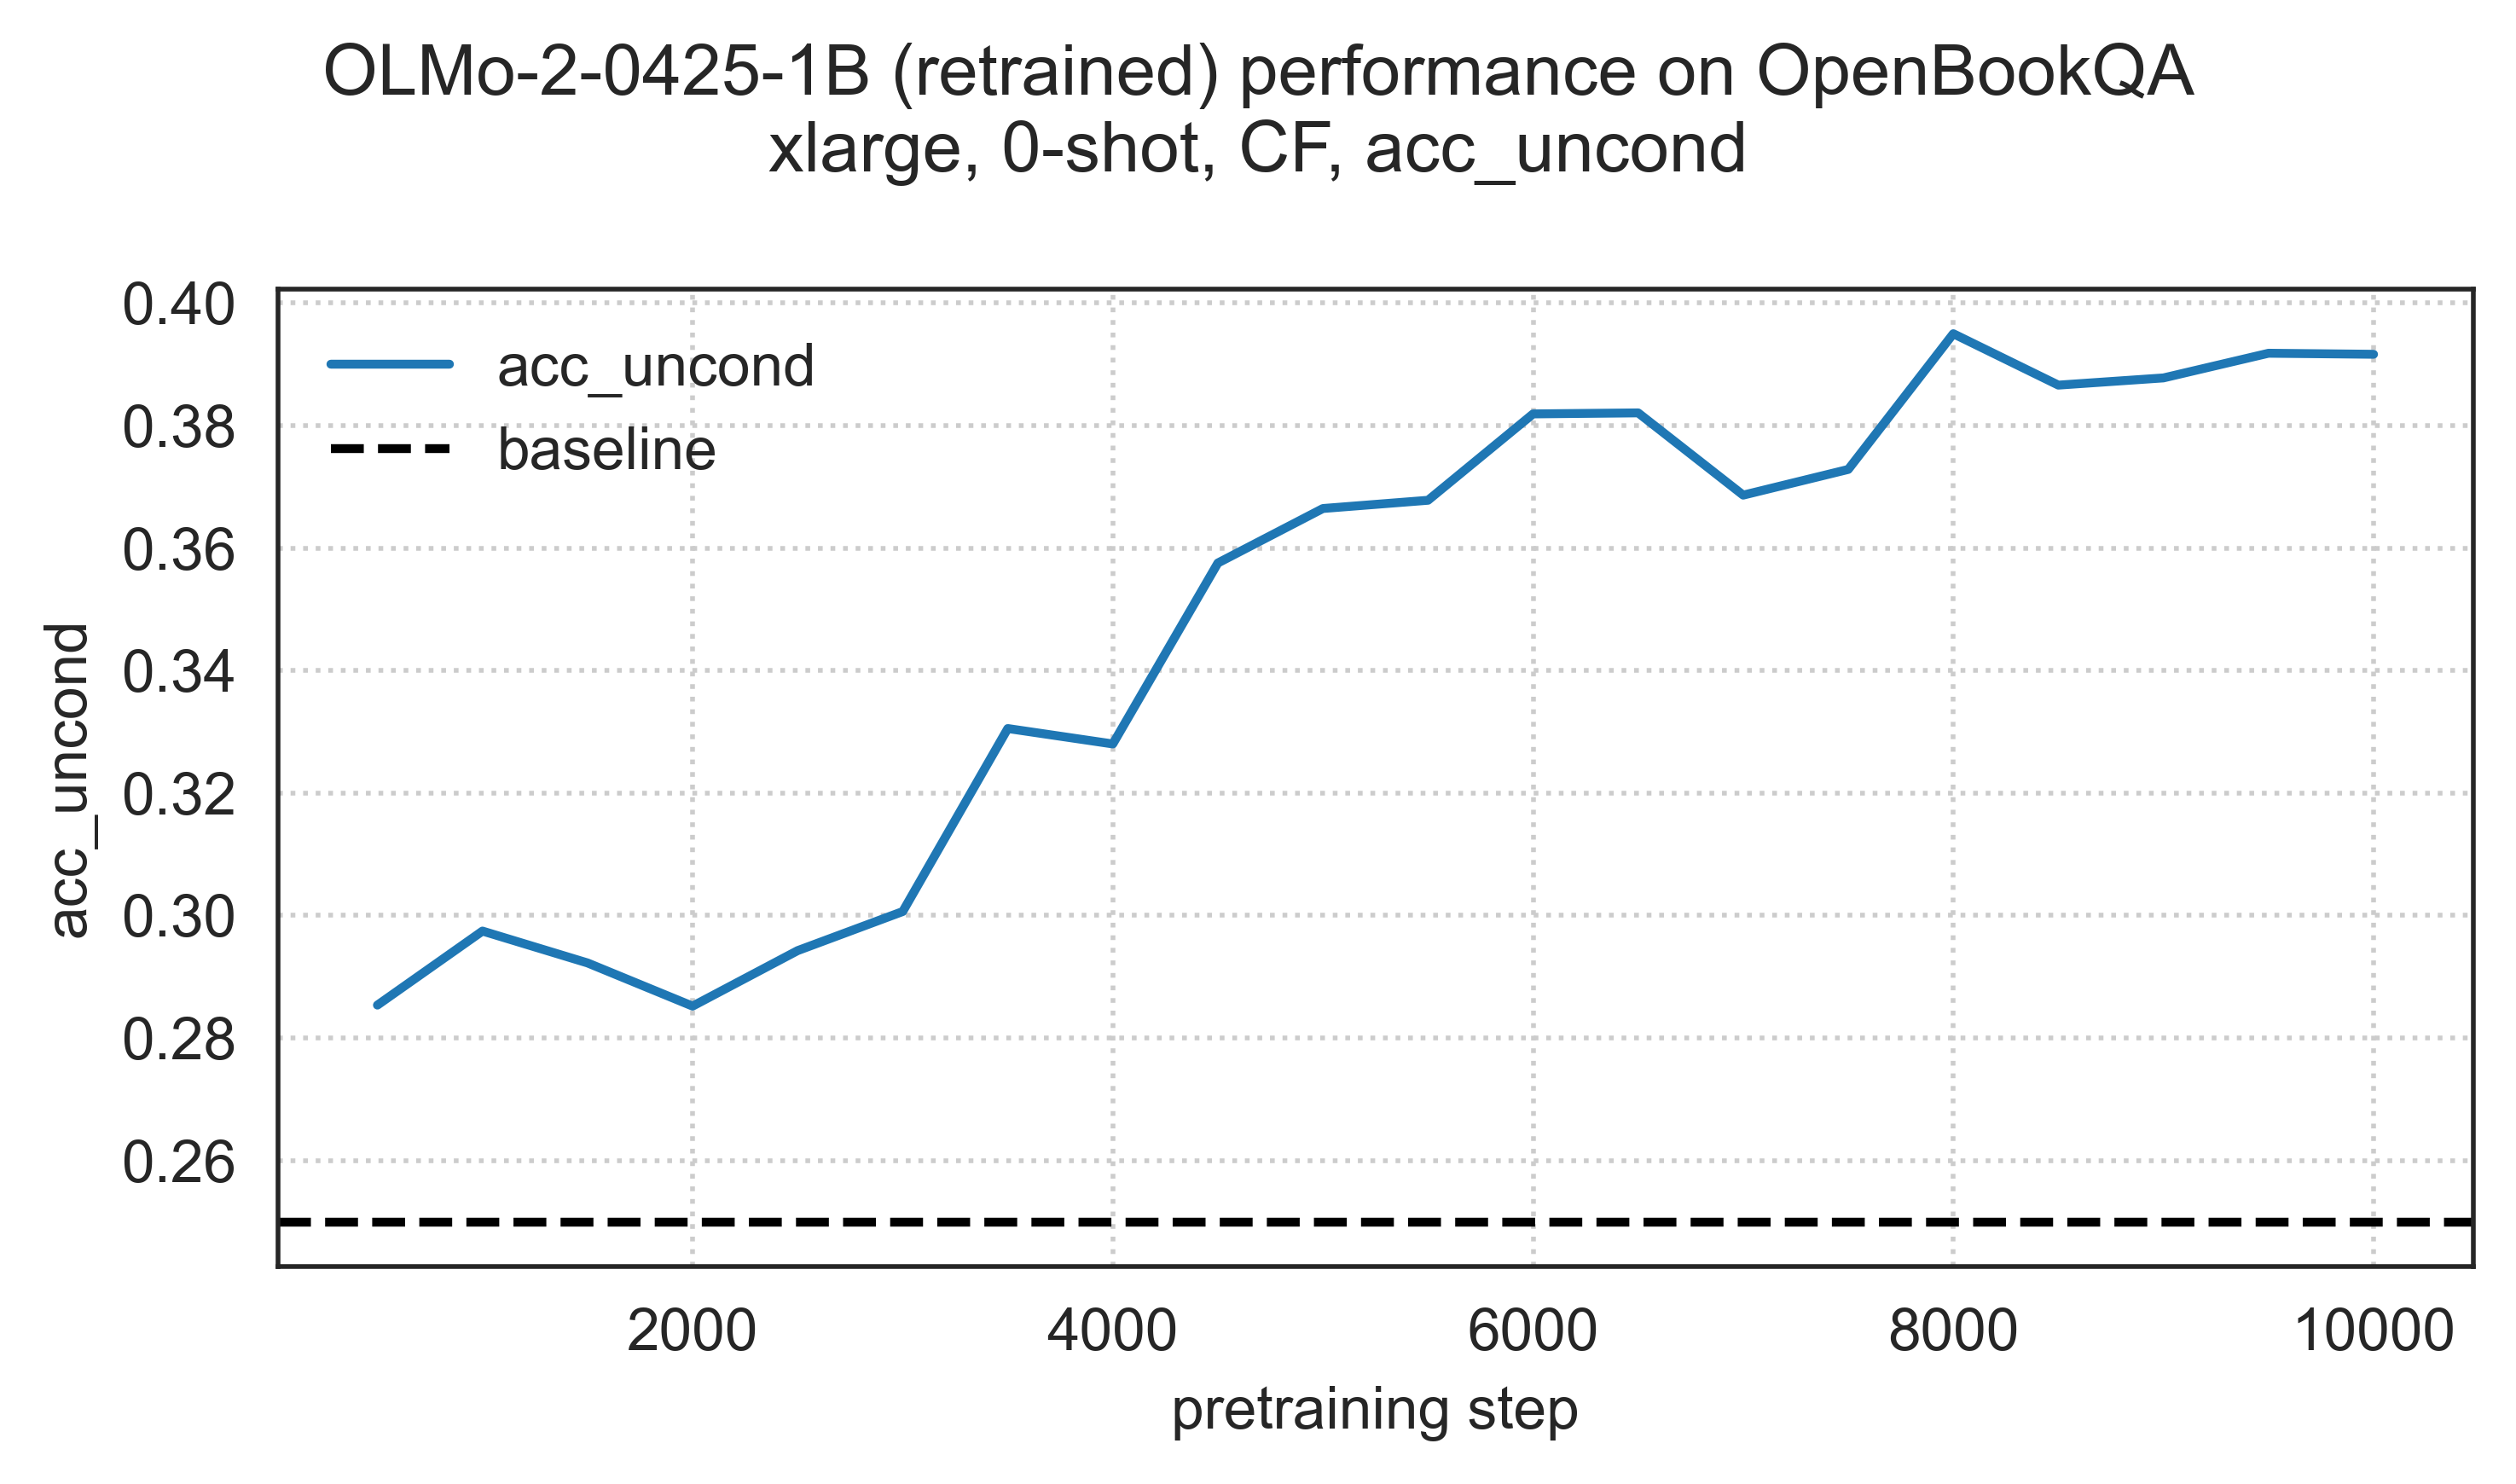

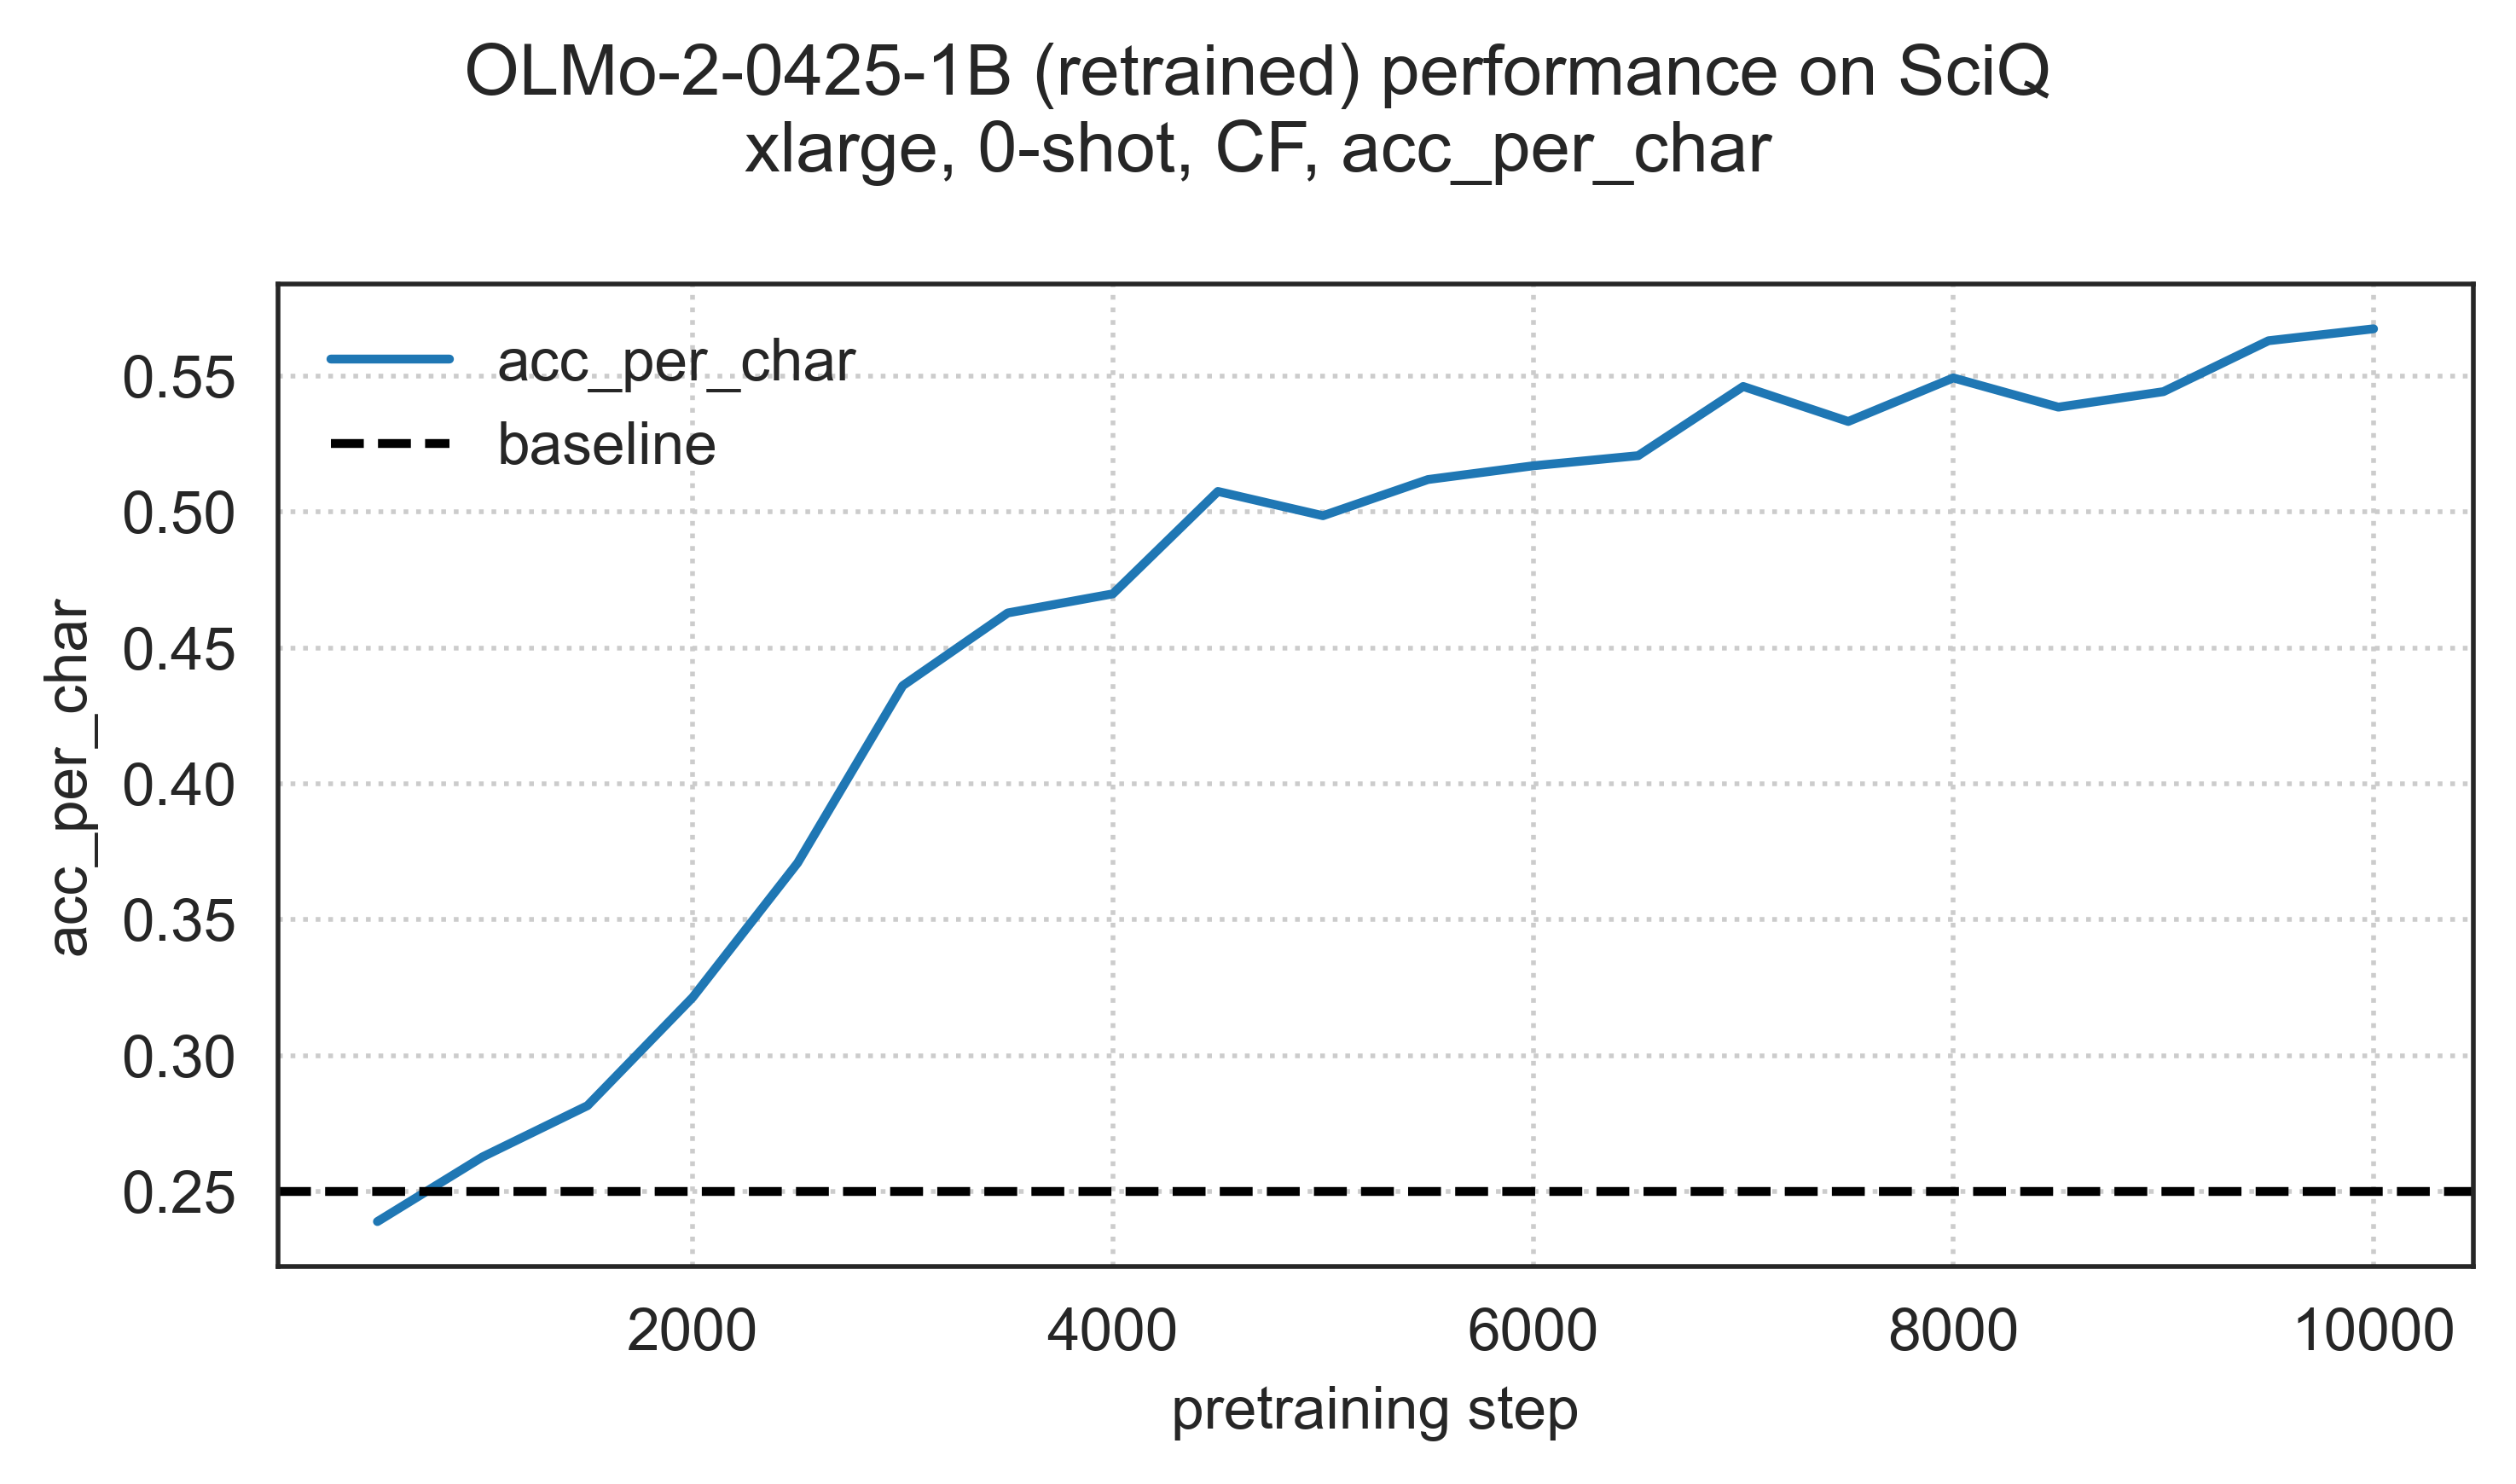

In [4]:
for dataset in datasets:
    fig = plt.figure(figsize=(6, 3.5))
    
    # plot overall mean accuracy
    plt.plot(ckpt_steps, np.mean(labels[dataset], axis=0), label=metrics[dataset])
    plt.axhline(0.25, linestyle="dashed", color="black", label="baseline")
    plt.grid(linestyle="dotted")
    plt.xlabel("pretraining step")
    plt.ylabel(metrics[dataset])
    
    plt.suptitle(f"OLMo-2-0425-1B (retrained) performance on {titles[dataset]}"
                 f"\n{subsets[dataset]}, 0-shot, CF, {metrics[dataset]}")
    plt.legend(loc="upper left", frameon=False)
    # plt.ylim(0, 0.6)
    plt.tight_layout()
    plt.show()

### Get histogram of learned checkpoints for each dataset

For each dataset, find the instances that are "definitively learned", i.e., there exists a checkpoint where that instance is always incorrect before and always correct after (their correctness label is a step function). For these instances, keep counts of at which checkpoints they're learned.

In [5]:
# get index of each instance that is "learned" and index of checkpoint
# that it is "learned" at
learned_ckpts = defaultdict(list)
learned_idxs = defaultdict(list)

for dataset in datasets:
    for i, row in enumerate(labels[dataset]):
        compressed = compress_binary_array(row)
        if len(compressed) == 2 and np.allclose(compressed, [0, 1]) or \
            len(compressed) == 1 and np.allclose(compressed, [1]):
            learned_ckpts[dataset].append(np.where(row == 1)[0][0])
            learned_idxs[dataset].append(i)
    learned_ckpts[dataset] = np.array(learned_ckpts[dataset])
    learned_idxs[dataset] = np.array(learned_idxs[dataset])

# get histogram of number of instances learned per checkpoint
binned_learned_ckpts = {
    dataset : np.bincount(learned_ckpts[dataset], minlength=len(ckpt_steps))
    for dataset in datasets
}
pprint(binned_learned_ckpts)

{'mmlu': array([705, 180, 160,  94,  61,  63,  43,  32,  24,  12,  10,  10,   3,
         6,   8,   7,   4,   4,   7,  65]),
 'openbookqa': array([49, 29, 38, 20, 47, 44, 37, 17,  6,  5,  5,  2,  2,  1,  0,  1,  1,
        2,  4, 22]),
 'sciq': array([1468,  393,  356,  410,  424,  445,  169,   77,   74,   27,   34,
         14,   14,    8,    6,    8,    5,    9,   24,   77])}


### Plot histogram of learned checkpoints

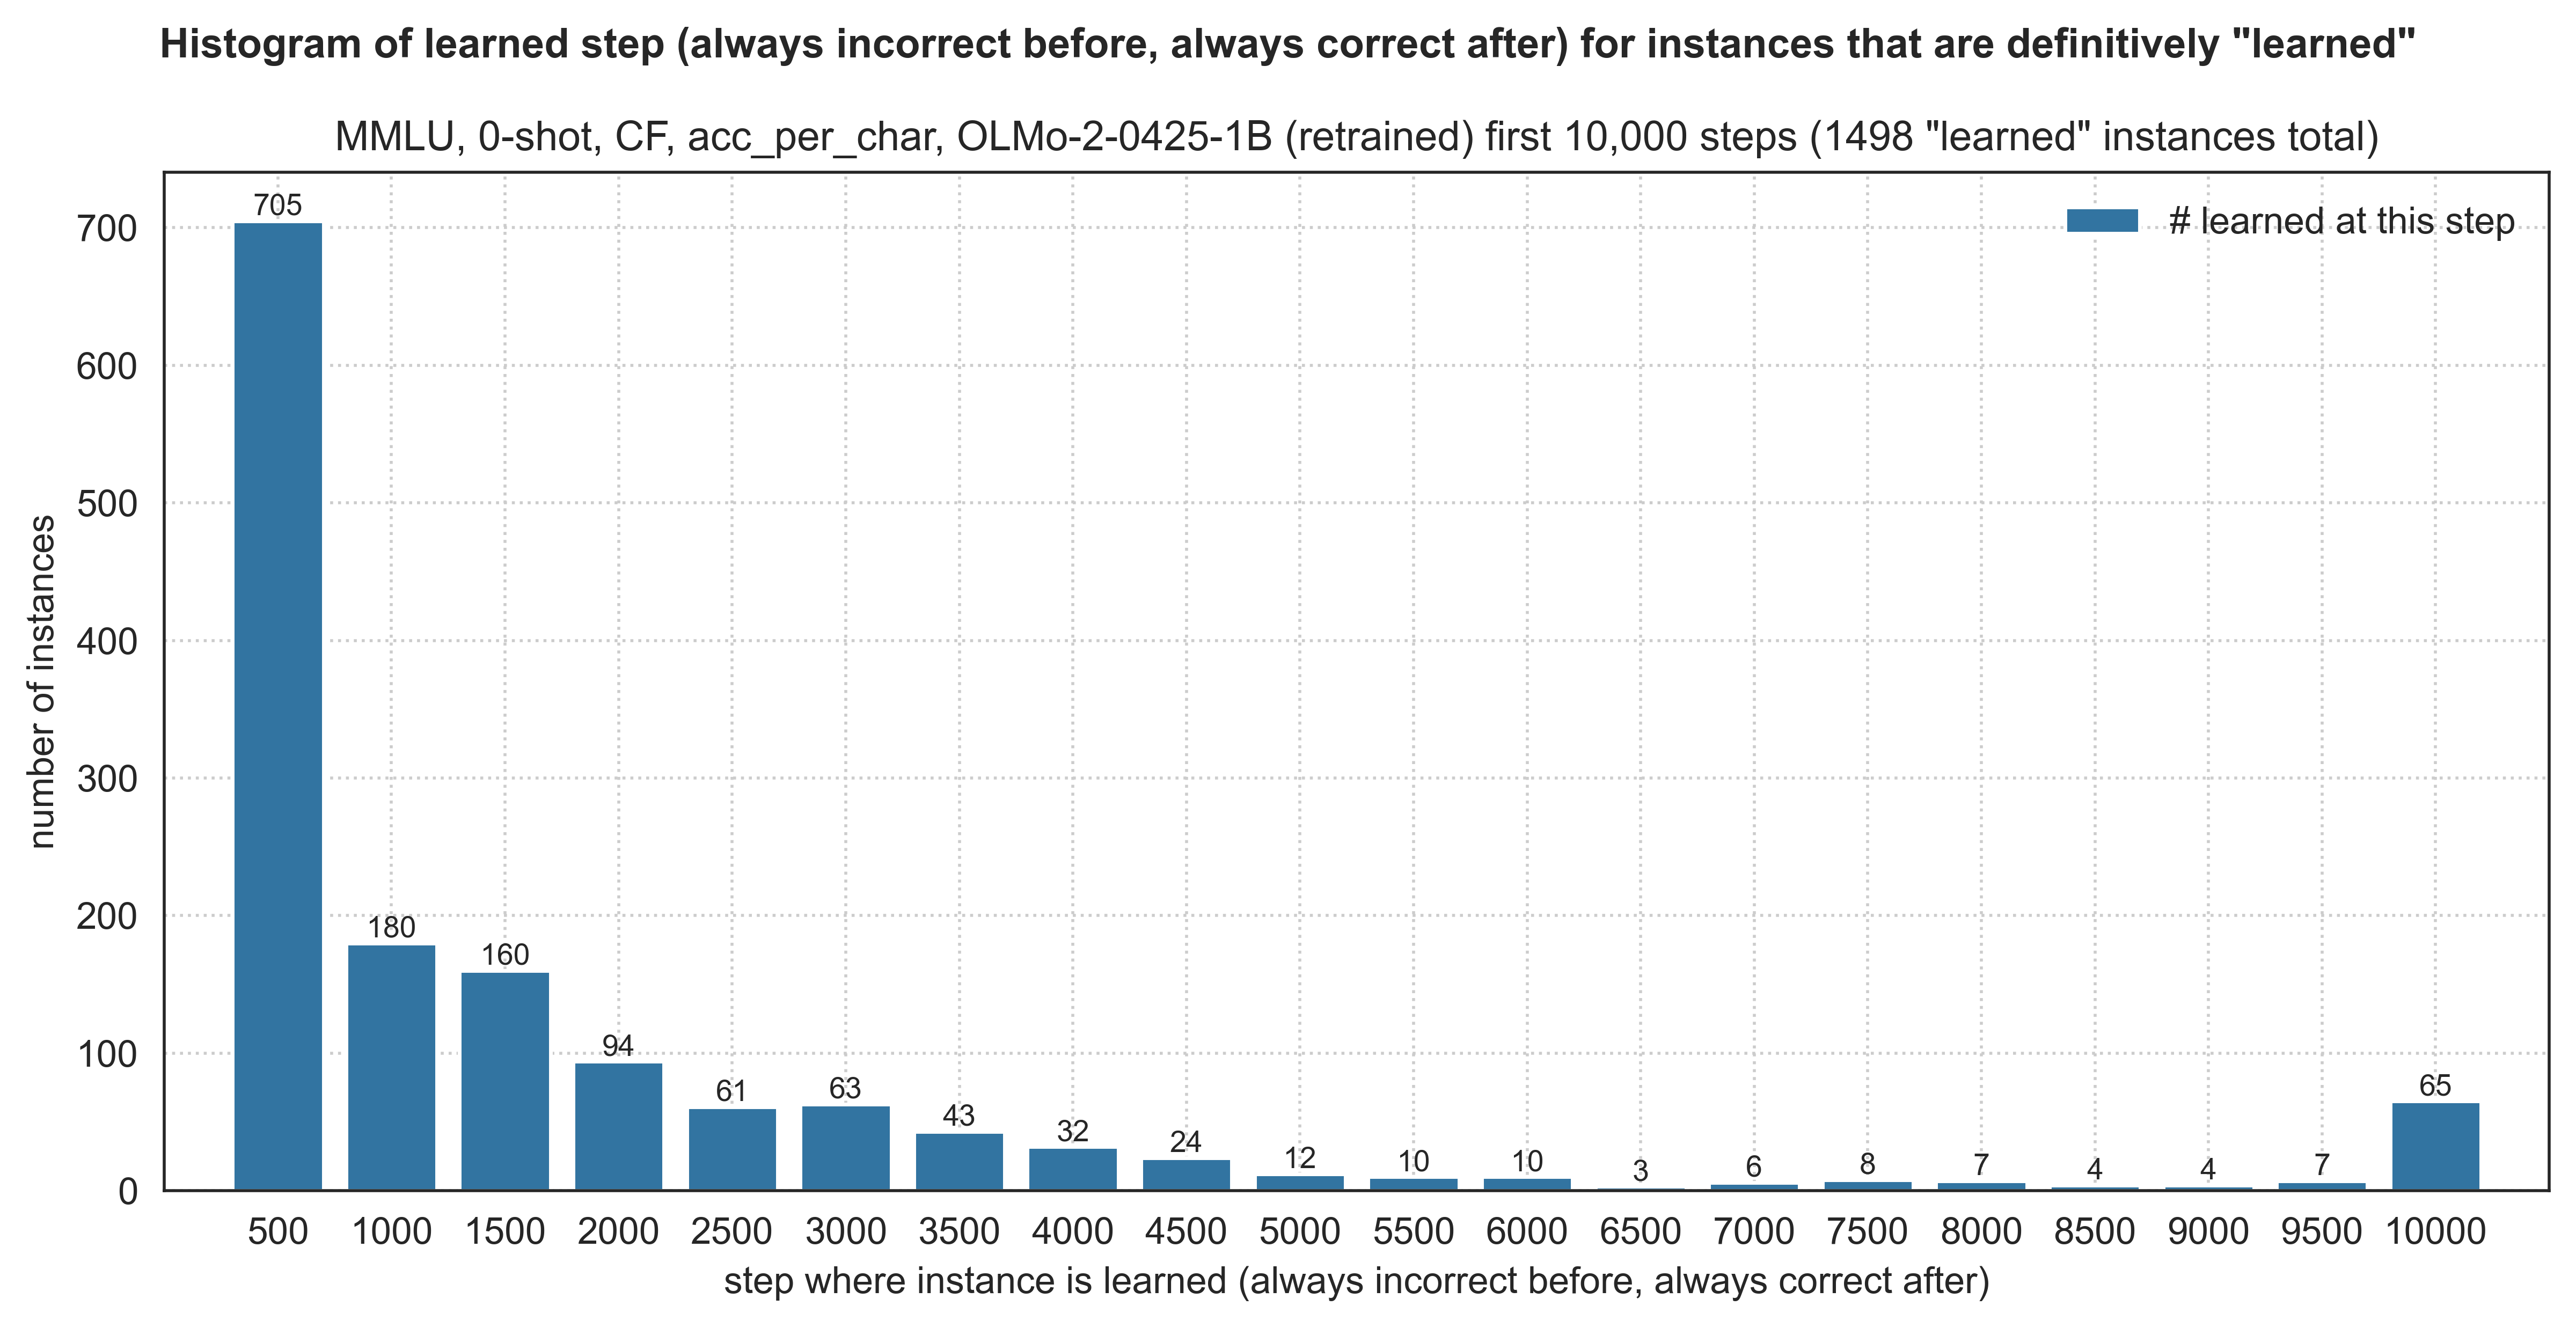

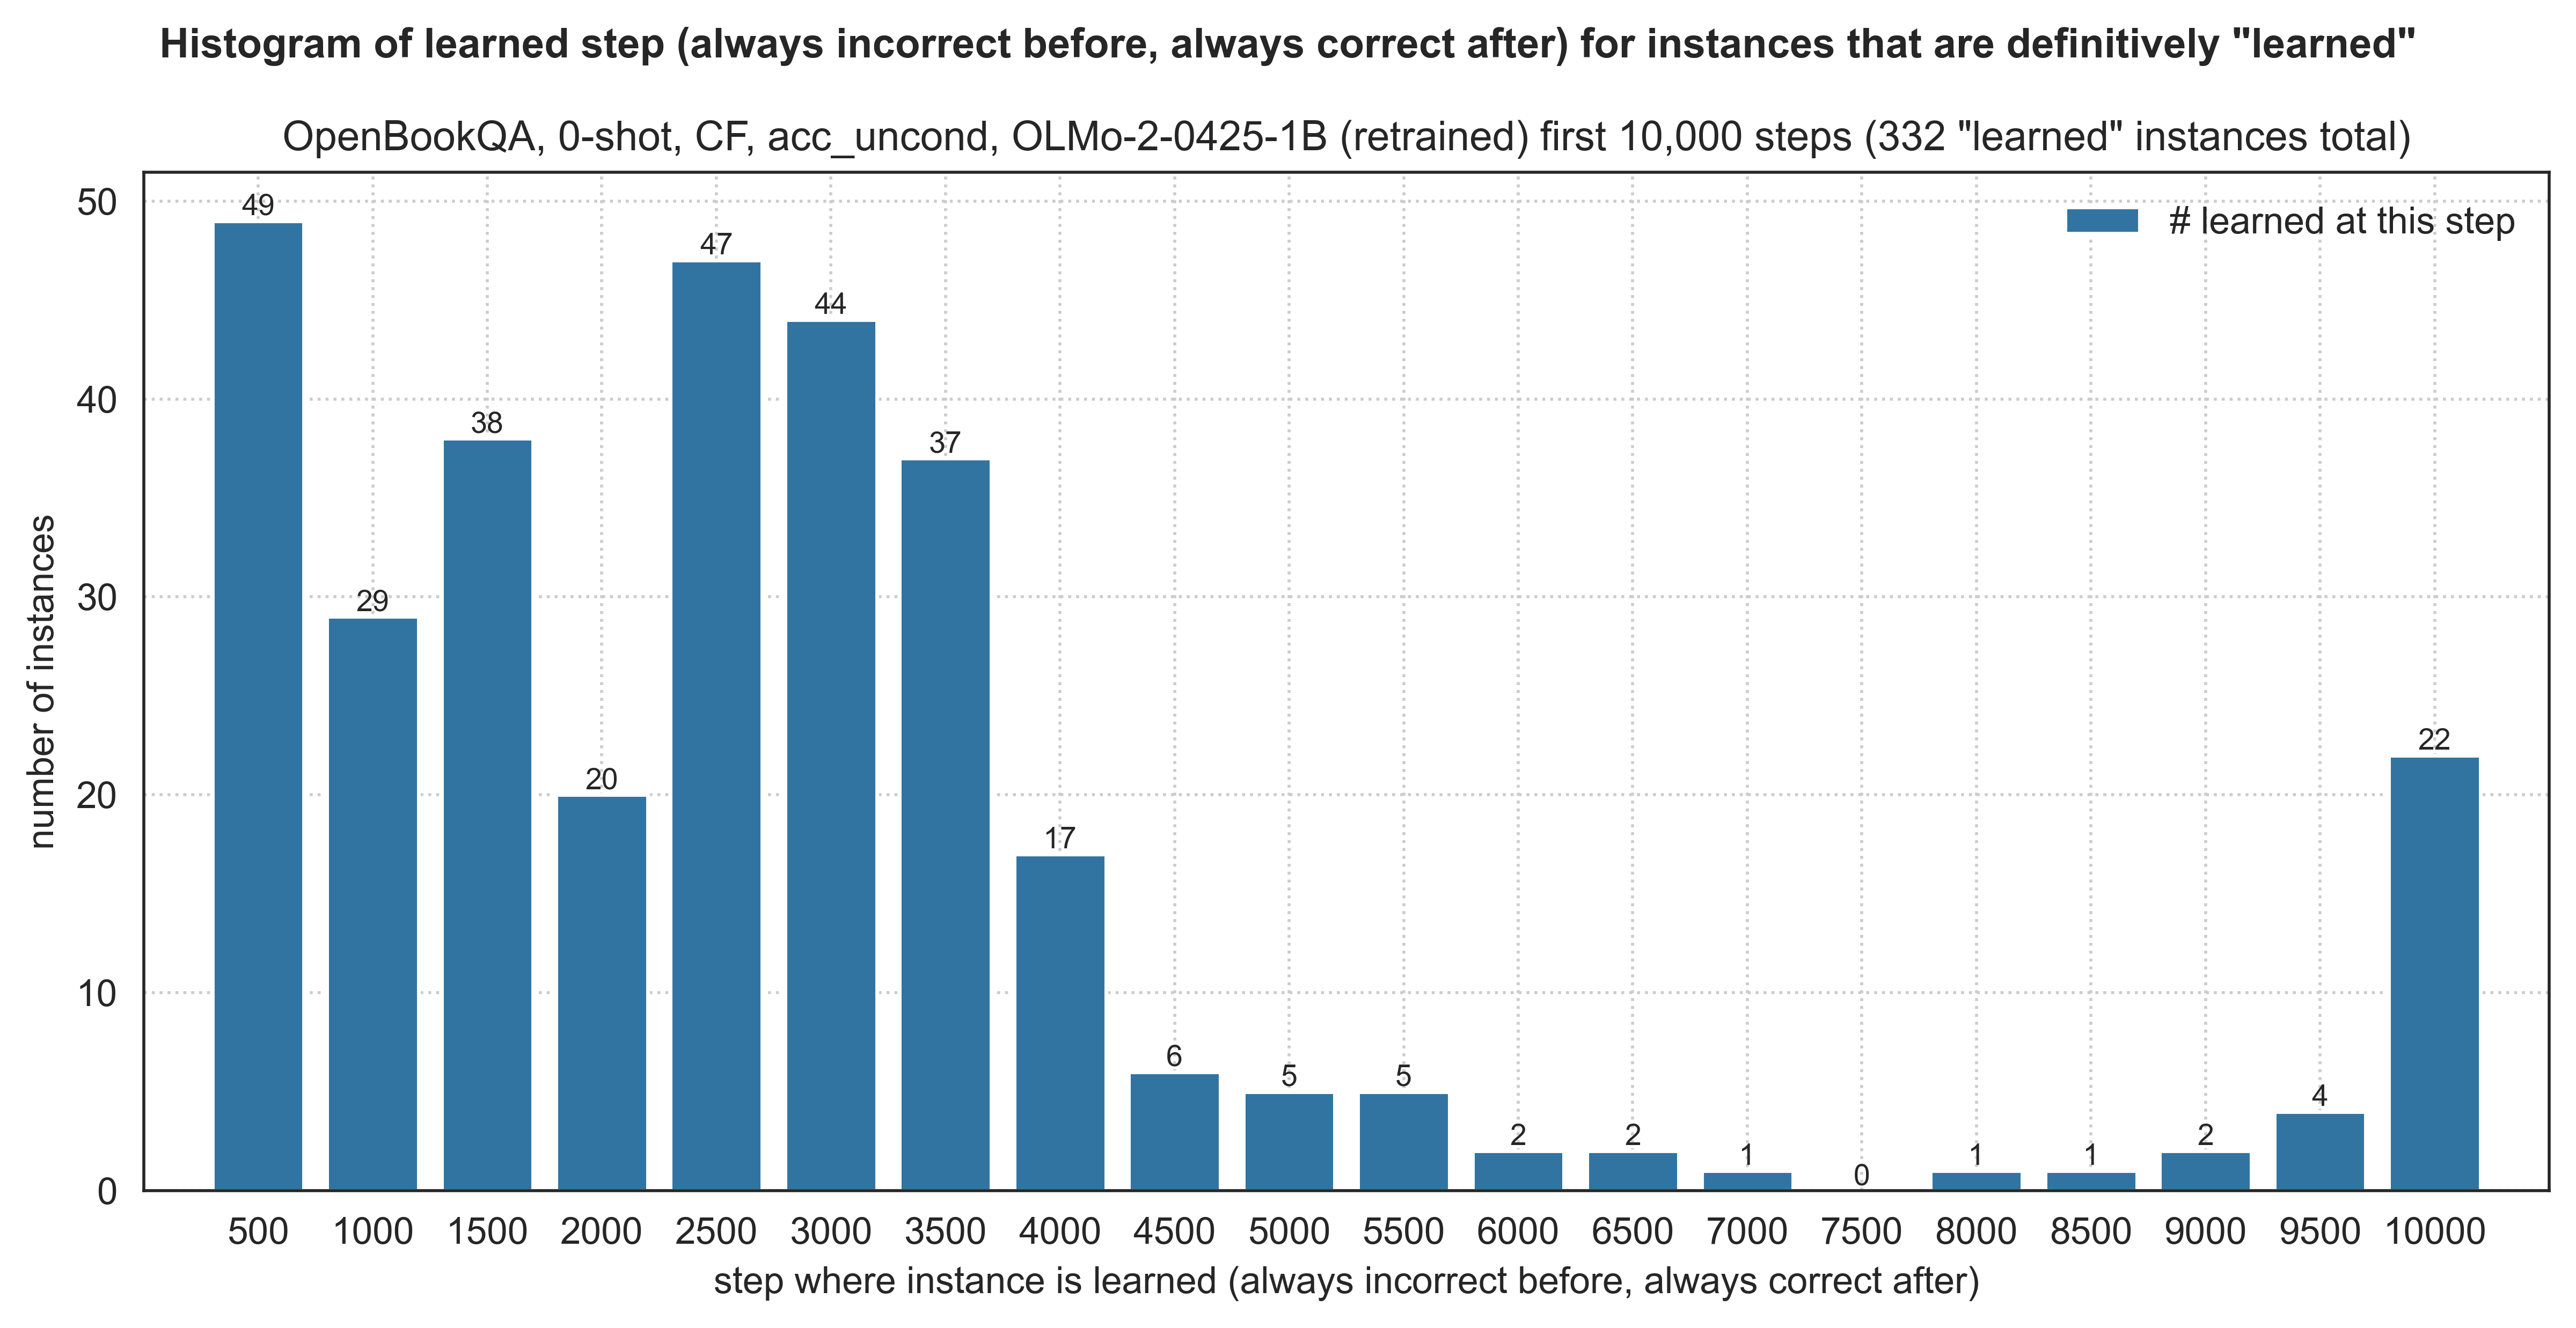

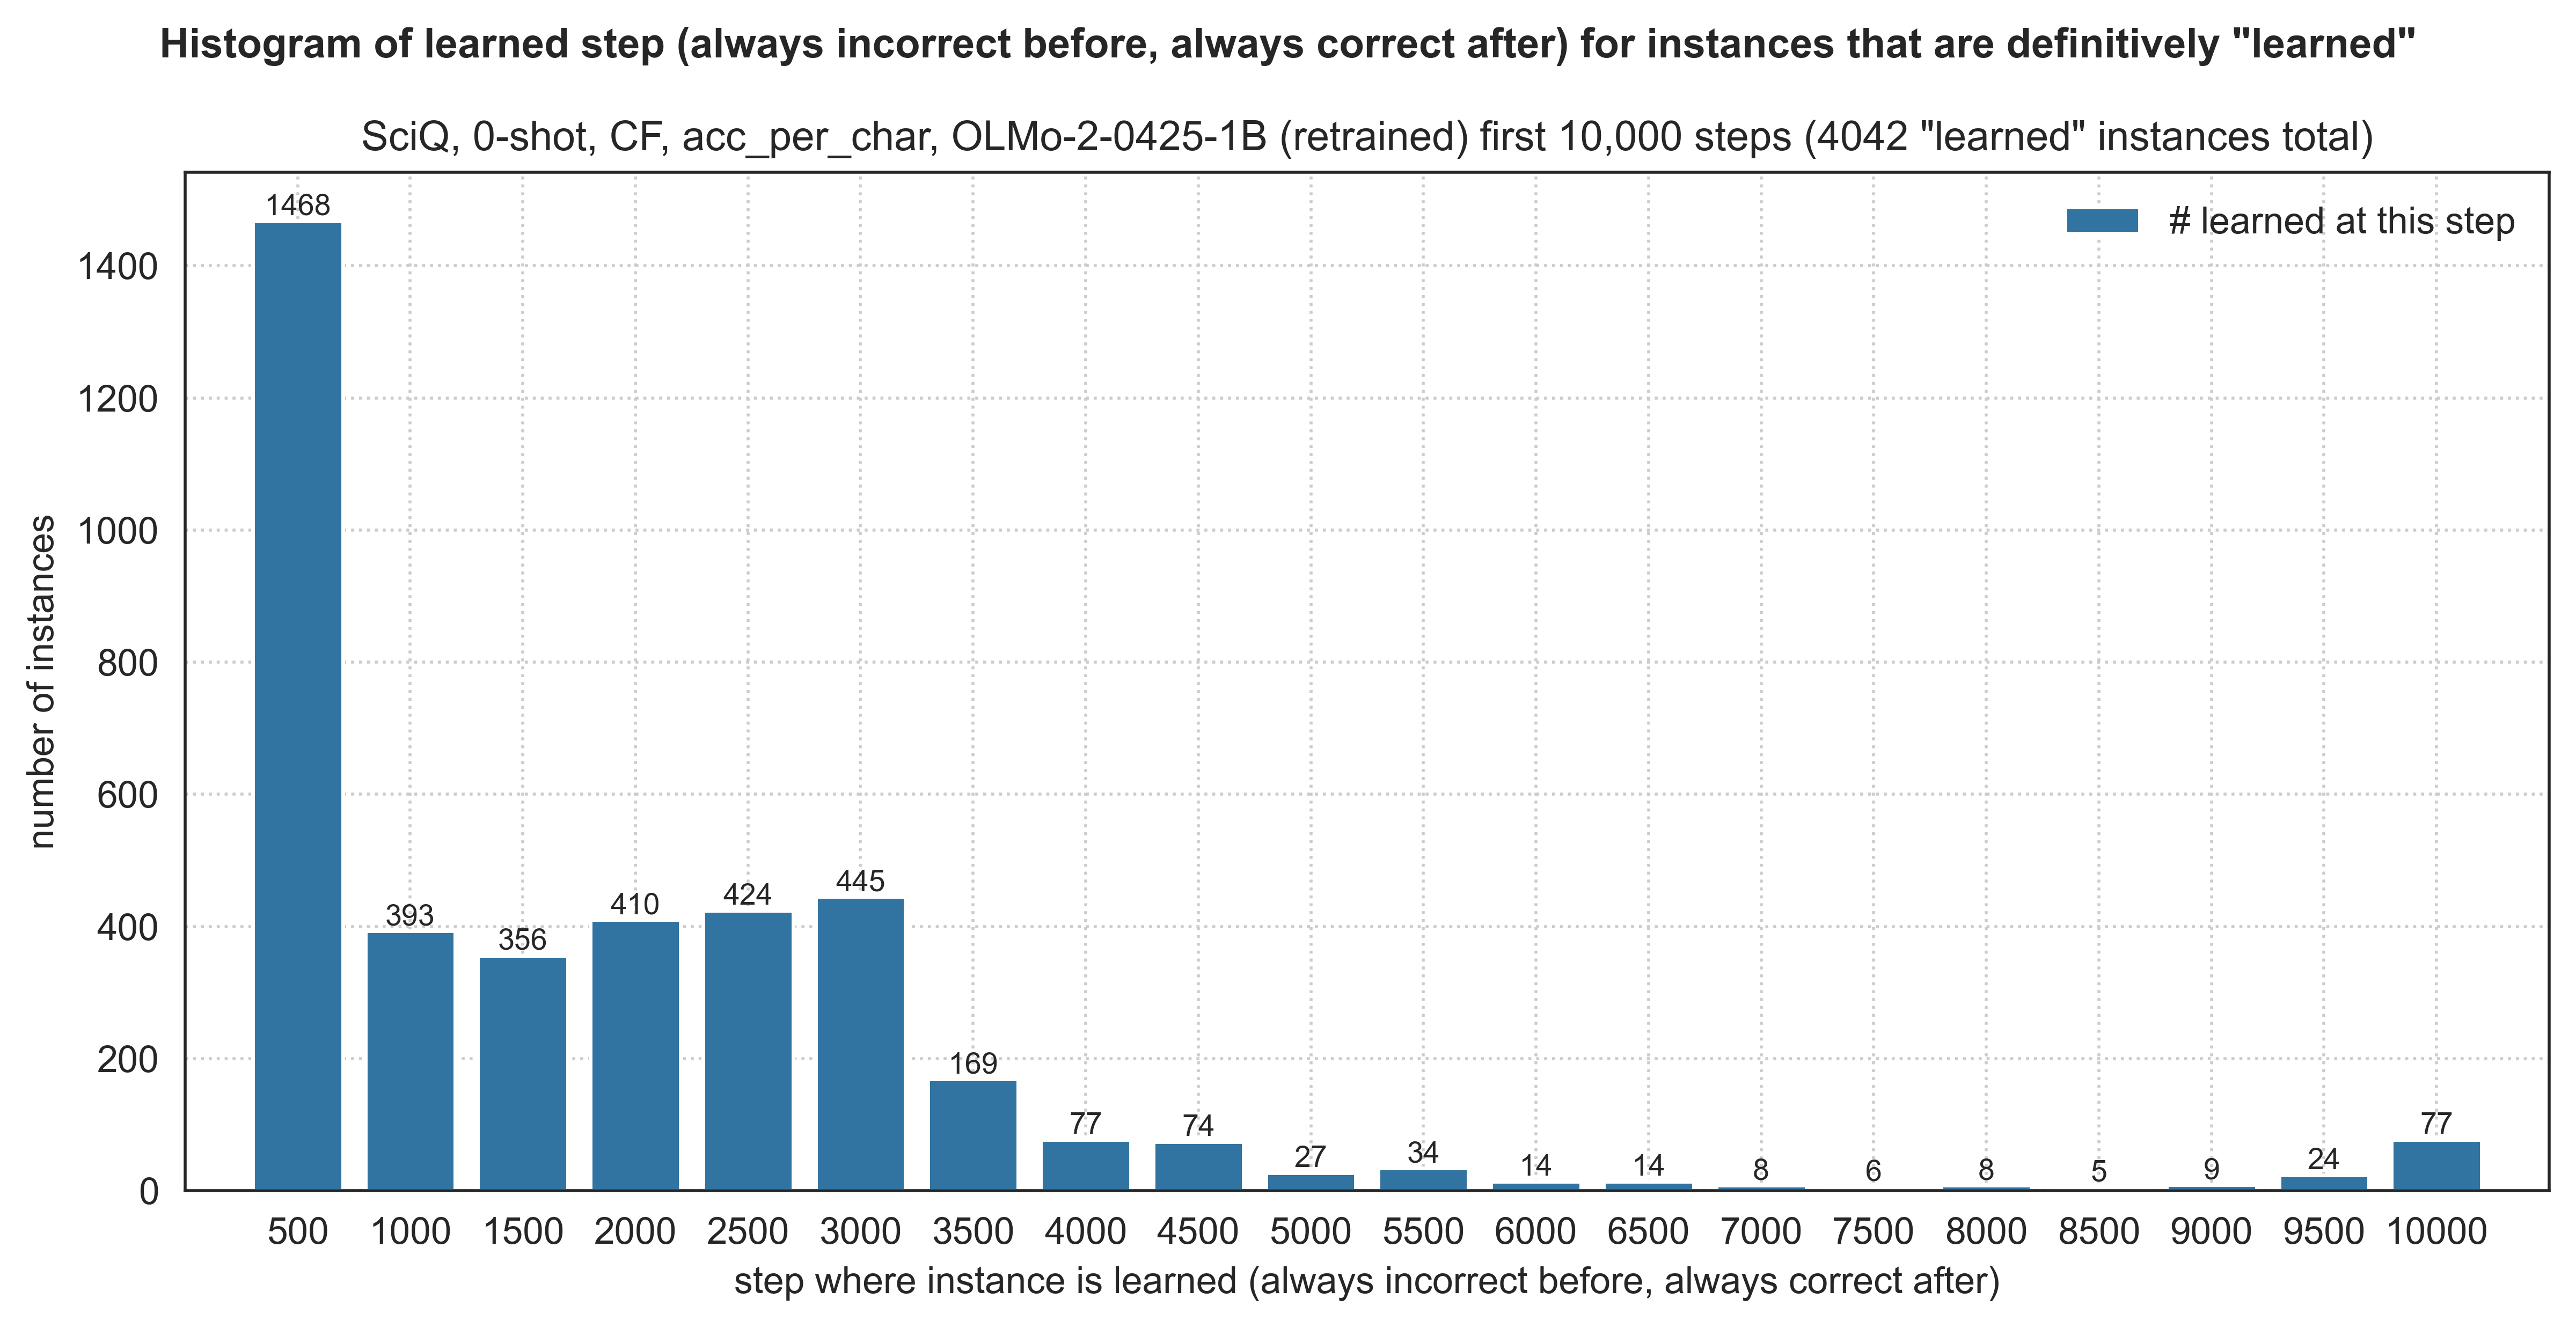

In [6]:
for dataset in datasets:

    plt.figure(figsize=(9.7, 5))
    
    # plot learned checkpoint histogram, label bars
    ax = sns.barplot(x=ckpt_steps[:len(binned_learned_ckpts[dataset])],
                     y=binned_learned_ckpts[dataset],
                     color="tab:blue",
                     label="# learned at this step")
    ax.bar_label(ax.containers[0], fontsize=8)
    
    # add axis grid, label axes
    plt.grid(linestyle="dotted")
    plt.xlabel("step where instance is learned (always incorrect before, "
               "always correct after)")
    plt.xticks(np.arange(len(ckpt_steps)), ckpt_steps)
    plt.xlim(-1, len(ckpt_steps))
    plt.ylabel("number of instances")
    
    # add titles, save figure to file
    plt.suptitle("Histogram of learned step (always incorrect before, "
                 "always correct after) for instances that are definitively "
                 "\"learned\"", fontweight="bold", fontsize=11)
    total_count = np.sum(binned_learned_ckpts[dataset])
    plt.title(f"{titles[dataset]}, 0-shot, CF, {metrics[dataset]}, OLMo-2-0425-1B (retrained) "
              f"first 10,000 steps ({total_count} \"learned\" instances total)",
              fontsize=11)
    plt.legend(loc="upper right", ncol=1, frameon=False)
    plt.tight_layout()
    plt.show()

### Save indices of instances learned at chosen step for each dataset

In [7]:
# MMLU, step 1500
orig_inst_idxs = learned_idxs["mmlu"][learned_ckpts["mmlu"] == 2]
assert len(orig_inst_idxs) == 160, "unexpected number of learned instances"
np.savez(f"{os.environ['HOME']}/projects/pretrain-intervention/data/swap_indices/"
         "orig_inst_idxs_olmo_mix_1124_mmlu_57subj_0shot_cf_char_learned_step_1500.npz",
         orig_inst_idxs=orig_inst_idxs)

# MMLU, step 2000
orig_inst_idxs = learned_idxs["mmlu"][learned_ckpts["mmlu"] == 3]
assert len(orig_inst_idxs) == 94, "unexpected number of learned instances"
np.savez(f"{os.environ['HOME']}/projects/pretrain-intervention/data/swap_indices/"
         "orig_inst_idxs_olmo_mix_1124_mmlu_57subj_0shot_cf_char_learned_step_2000.npz",
         orig_inst_idxs=orig_inst_idxs)

# OpenBookQA, step 2500
orig_inst_idxs = learned_idxs["openbookqa"][learned_ckpts["openbookqa"] == 4]
assert len(orig_inst_idxs) == 47, "unexpected number of learned instances"
np.savez(f"{os.environ['HOME']}/projects/pretrain-intervention/data/swap_indices/"
         "orig_inst_idxs_olmo_mix_1124_openbookqa_xlarge_0shot_cf_uncond_learned_step_2500.npz",
         orig_inst_idxs=orig_inst_idxs)

# OpenBookQA, step 3000
orig_inst_idxs = learned_idxs["openbookqa"][learned_ckpts["openbookqa"] == 5]
assert len(orig_inst_idxs) == 44, "unexpected number of learned instances"
np.savez(f"{os.environ['HOME']}/projects/pretrain-intervention/data/swap_indices/"
         "orig_inst_idxs_olmo_mix_1124_openbookqa_xlarge_0shot_cf_uncond_learned_step_3000.npz",
         orig_inst_idxs=orig_inst_idxs)

# SciQ, step 2500
orig_inst_idxs = learned_idxs["sciq"][learned_ckpts["sciq"] == 4]
assert len(orig_inst_idxs) == 424, "unexpected number of learned instances"
np.savez(f"{os.environ['HOME']}/projects/pretrain-intervention/data/swap_indices/"
         "orig_inst_idxs_olmo_mix_1124_sciq_xlarge_0shot_cf_char_learned_step_2500.npz",
         orig_inst_idxs=orig_inst_idxs)

# SciQ, step 3000
orig_inst_idxs = learned_idxs["sciq"][learned_ckpts["sciq"] == 5]
assert len(orig_inst_idxs) == 445, "unexpected number of learned instances"
np.savez(f"{os.environ['HOME']}/projects/pretrain-intervention/data/swap_indices/"
         "orig_inst_idxs_olmo_mix_1124_sciq_xlarge_0shot_cf_char_learned_step_3000.npz",
         orig_inst_idxs=orig_inst_idxs)